<span style="font-size:large;">
<div style="text-align: right">CSTS-UH 1078 <b>Networks</b><br/>
Student name: <span style="color:blue"><b>Sashank Silwal</b></span><br/>
Grade: <span style="color:red"><b></b></span><br/><br/></div>

## <span style="color:red">HOMEWORK 6</span>
# <span style="color:green">The Graph of Sententially Co-Occurrent 2-Grams in Text Data

1. <span style="color:blue"><b>Below, replace "/Users/mb7881/WorkPlaces/Python Projects 2/2 NYUAD Networks/CourseNotebooks/Homework 6" by the position of the folder of this notebook in your computer, inside which you should also include a text file of a book or novel.

2. <span style="color:blue"><b>Dowload the txt file of a book (with Chapters) from http://www.gutenberg.org/ and after you remove the preamble (your text should start from the first chapter) and the end disclaimers (your text should end at the end of the book) place it in cell 2 under an appropriate name.

3. <span style="color:blue"><b>Subsequently run all cells and interpret the network plot of the last cell (remember that edge colors correspond to sentiment scores).

In [1]:
import pandas as pd
import numpy as np
import urllib2 
import re, string, math, random, operator
import nltk
nltk.download('punkt')
from textblob import TextBlob
import codecs
import os
os.chdir("/Users/sashanksilwal/Desktop/Freshman /Networks/Homework6")
from sklearn.feature_extraction.text import TfidfVectorizer #, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from collections import Counter
import itertools as it
import community
import networkx as nx
from networkx.algorithms import bipartite
from networkx.drawing.nx_agraph import graphviz_layout
import pygraphviz
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sashanksilwal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Load data

In [2]:
filename = 'pinocchio.txt' # Insert in quotes the name of your txt file, e.g. "PeterPan.txt"
titlename = "Pinocchio"   # Insert in quotes the name of the novel (or book), e.g., "Peter Pan"

f = codecs.open(filename, "r", encoding="utf-8").readlines()

num_lines = 0
num_words = 0
num_chars = 0
for line in f:
    words = line.split()
    num_lines += 1
    num_words += len(words)
    num_chars += len(line)
print "%s has number of words = %i (and number of characters/symbols = %i)" %(titlename,num_words,num_chars)

Pinocchio has number of words = 41710 (and number of characters/symbols = 231328)


In [3]:
text="\n".join(f).split("CHAPTER")
len(text)

37

## 2-Grams

In [4]:
# 2-grams vectorization of text
vectorizer = TfidfVectorizer(stop_words = 'english', ngram_range=(2,2))  #(1,2)
X = vectorizer.fit_transform(text)
words = vectorizer.get_feature_names()
# print("words", len(words),words) 

In [5]:
n_clusters=5 #len(text)
number_of_terms=500
number_of_seeds_to_try=10
max_iter = 500
number_of_process=2 # seads are distributed
model = KMeans(n_clusters=n_clusters, max_iter=max_iter, n_init=number_of_seeds_to_try, n_jobs=number_of_process).fit(X)

labels = model.labels_
ordered_words = model.cluster_centers_.argsort()[:, ::-1]
centers=model.cluster_centers_

text_per_cluster = np.zeros(n_clusters)
for i_cluster in range(n_clusters):
    for label in labels:
        if label==i_cluster:
            text_per_cluster[i_cluster] +=1 

top_2grams=[]
for i_cluster in range(n_clusters):
    for term in ordered_words[i_cluster, :number_of_terms]: 
        if term not in top_2grams:
            top_2grams.append(words[term])

top_2grams=[t for t in top_2grams if len(t)>2]            
top_2grams=sorted(set(top_2grams))
top_2grams=[w.encode('utf8').decode('utf8').encode("ascii","ignore") for w in top_2grams] 
print("top 2grams",len(top_2grams))
top_2grams[:10]

('top 2grams', 2425)


['able draw',
 'absolutely hunger',
 'according wishes',
 'account forgiven',
 'accounts squared',
 'accounts tomorrow',
 'acquired pinocchio',
 'acrobat puppet',
 'acting watch',
 'acts watch']

## Sentences

In [6]:
textSentences=[]
for t in text:
    blob = TextBlob(t)
    ts = blob.sentences
    textSentences.append(ts)
textSentences = [item for sublist in textSentences for item in sublist]
print(len(textSentences))
textSentences[:10]

2860


[Sentence(" I
 
 
 
 THE PIECE OF WOOD THAT LAUGHED AND CRIED LIKE A CHILD
 
 
 
 
 
 There was once upon a time a piece of wood in the shop of an old
 
 carpenter named Master Antonio."),
 Sentence("Everybody, however, called him Master
 
 Cherry, on account of the end of his nose, which was always as red and
 
 polished as a ripe cherry."),
 Sentence("No sooner had Master Cherry set eyes on the piece of wood than his face
 
 beamed with delight, and, rubbing his hands together with satisfaction,
 
 he said softly to himself:
 
 
 
 "This wood has come at the right moment; it will just do to make the leg
 
 of a little table.""),
 Sentence("He immediately took a sharp axe with which to remove the bark and the
 
 rough surface, but just as he was going to give the first stroke he
 
 heard a very small voice say imploringly, "Do not strike me so hard!""),
 Sentence("He turned his terrified eyes all around the room to try and discover
 
 where the little voice could possibly have come fr

In [7]:
sendic=dict()
for i,v in enumerate(textSentences):
    sent=v.sentiment.polarity
    wl=[]
    for term in top_2grams:
        if term in v: 
            wl.append(term)
    if len(wl)>1:
        sendic[i]=wl 
# sendic

## Co-Occurrences of 2-Grams in Sentences

In [8]:
medges=[]
for k,v in sendic.items():
    sent=textSentences[k].sentiment.polarity
    dd={}
    ps=set()
    for j in it.combinations(v, 2):
        ps.add(j)
        dd[j]=(k,sent)
    for jj in ps:
        s=0
        ss=0
        for kk,vv in dd.items():
            if kk==jj:
                s+=1
                ss+=vv[1]
        medges.append((jj[0],jj[1],"Sentence_"+str(k),ss/float(s)))
print len(medges) 
S=len(medges)
# medges

334


In [9]:
medgesd=[]
for e in medges:
    d={}
    d['Sentence']=e[2]
    d['Average sentiment']=e[3]
    medgesd.append((e[0],e[1],d))
# for e in medgesd:
#     print e

In [10]:
G = nx.MultiGraph()
G.add_edges_from(medgesd)
for e in G.edges(data=True):
    if e[0]==e[1]:
        G.remove_edge(e[0],e[1])
print "Nodes =",len(G.nodes())
print "Multiedges =",len(G.edges())
# for e in G.edges(data=True):
#     print e

Nodes = 227
Multiedges = 334


In [11]:
df = nx.to_pandas_edgelist(G) 
# df
df.rename(columns={'source':'First 2-gram term','target':'Second 2-gram term'}, inplace=True)
df=df[['First 2-gram term','Second 2-gram term','Average sentiment','Sentence']]
df.head()

,First 2-gram term,Second 2-gram term,Average sentiment,Sentence
0,hot embers,earthenware saucer,0.35000,Sentence_239
1,poor old,old man,-0.08750,Sentence_1007
2,fell asleep,came straight,0.00625,Sentence_1221
3,fell asleep,little outburst,0.00625,Sentence_1221
4,fell asleep,burnt away,-0.12500,Sentence_269


In [12]:
weight={(x,y):v['Average sentiment'] for x,y,v in G.edges(data=True)}
w_edges=[(x,y,z) for (x,y),z in weight.items()]
Gw = nx.Graph()
Gw.add_weighted_edges_from(w_edges)
N=len(Gw.nodes())

In [13]:
print "Graph Gw is a weighted graph with %i nodes and %i edges" %(len(Gw.nodes()),len(Gw.edges()))
print "The density of Gw is %.3f" %nx.density(Gw)
if nx.is_connected(Gw)==True:
    print "Gw is a connected graph"
else:
    print "Gw is a disconnected graph and it has",nx.number_connected_components(Gw),"connected components"    
giant = max(nx.connected_component_subgraphs(Gw), key=len)
Gwlcc=Gw.subgraph(giant)
print "The largest connected component of Gw is a weighted graph with %i nodes and %i edges" %(len(Gwlcc.nodes()),len(Gwlcc.edges()))
print "The density of the largest connected component of Gw is %.3f" %nx.density(Gwlcc)

lccmedges=[]
for e in medges:
    if e[0] in giant and e[1] in giant:
        lccmedges.append((e[0],e[1]))
NN=len(Gwlcc.nodes())
SS=len(lccmedges)

Graph Gw is a weighted graph with 227 nodes and 307 edges
The density of Gw is 0.012
Gw is a disconnected graph and it has 51 connected components
The largest connected component of Gw is a weighted graph with 83 nodes and 168 edges
The density of the largest connected component of Gw is 0.049


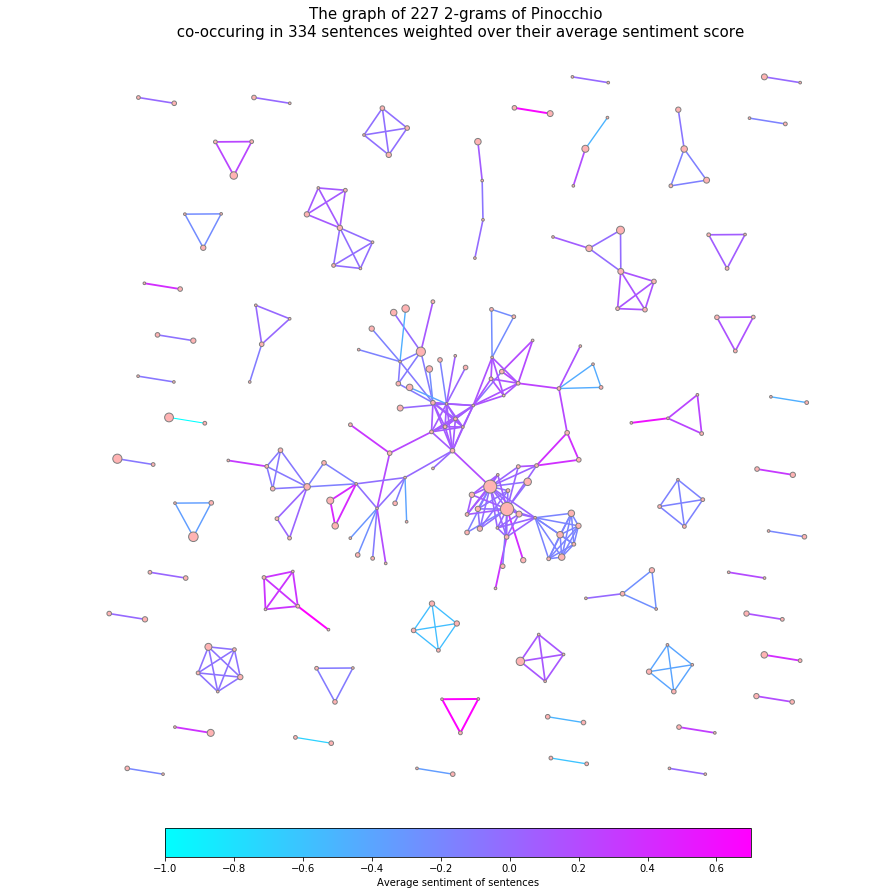

In [14]:
edge_width=[Gw[u][v]['weight'] for u,v in Gw.edges()]
# elabels = nx.get_edge_attributes(Gw,'weight')
edge_width1=[10*(0.1+w) for w in edge_width] 
# print edge_width

figsize=(15,17)

cmap=plt.cm.cool
weight_list = [ e[2]['weight'] for e in Gw.edges(data=True) ]
edge_color=weight_list
vmin = min(edge_color) 
vmax = max(edge_color) 
# width_list=[2*math.log(2+w) for w in weight_list]
width_list=[1.5*math.log(abs(min(weight_list))+2+w) for w in weight_list] #weight_list

pos=graphviz_layout(Gw) 
node_color="#ffb3b3"
node_border_color="grey"
# edge_color="#668cff"

d = Gw.degree()
node_size=[7*v[1] for v in list(nx.degree(G))]

plt.figure(figsize=figsize);
nodes = nx.draw_networkx_nodes(Gw, pos,node_color=node_color,node_size=node_size)
nodes.set_edgecolor(node_border_color)
# nx.draw_networkx_edges(G, pos, edge_color=edge_color,width=edge_width,a=1)
nx.draw_networkx_edges(Gw, pos,width=width_list,edge_color=edge_color,edge_cmap=cmap,vmin=vmin, vmax=vmax,alpha=1)
labels_no={}
for n in G.nodes():
    labels_no[n]=''
nx.draw_networkx_labels(G, pos,labels=labels_no)
# nx.draw_networkx_edge_labels(G,pos,edge_labels=elabels);
plt.axis('off');
# yoffset = {}
# y_off = -15   # offset on the y axis
# for k, v in pos.items():
#     yoffset[k] = (v[0], v[1]+y_off)
# nx.draw_networkx_labels(Gw, yoffset,font_size=8);
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, orientation='horizontal', shrink=0.7, pad = 0.02)
cbar.set_label('Average sentiment of sentences')
sst="The graph of %i 2-grams of %s \n co-occuring in %i sentences weighted over their average sentiment score" %(N,titlename,S) 
plt.title(sst,fontsize=15);
plt.margins(x=0.1, y=0.05) 

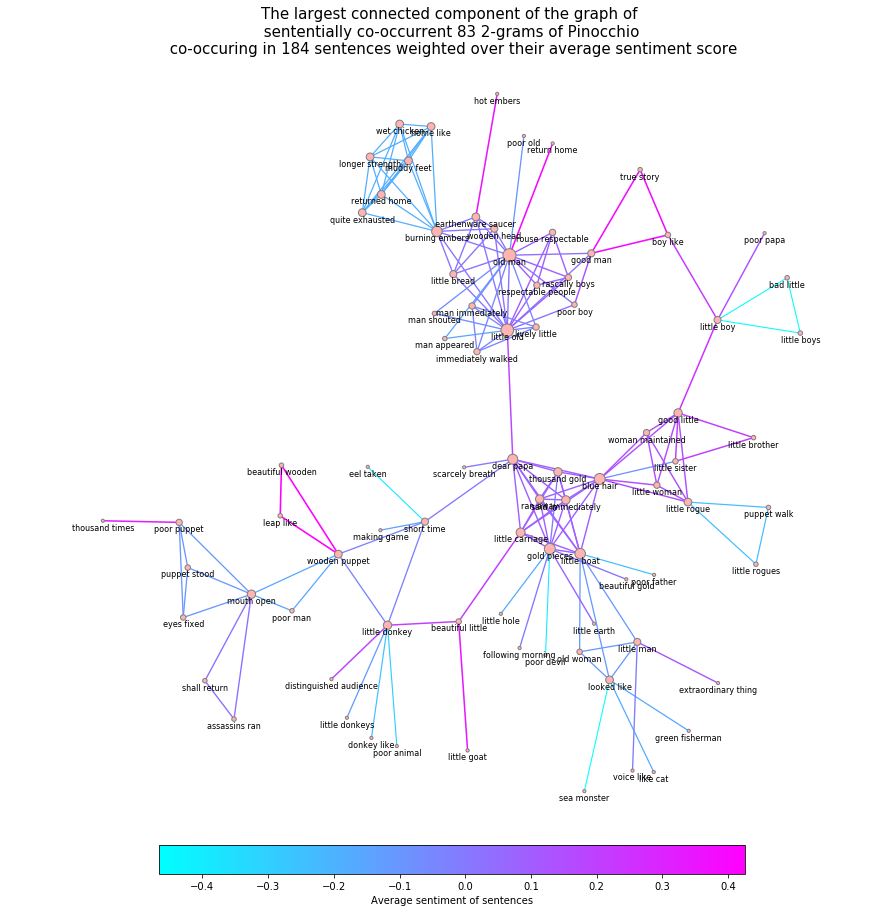

In [15]:
figsize=(15,17)

cmap=plt.cm.cool
weight_list = [ e[2]['weight'] for e in Gwlcc.edges(data=True) ]

edge_color=weight_list
vmin = min(edge_color) 
vmax = max(edge_color) 
width_list=[1.5*math.log(abs(min(weight_list))+2+w) for w in weight_list] #weight_list

pos=graphviz_layout(Gwlcc) 
node_color="#ffb3b3"
node_border_color="grey"
# edge_color="#668cff"

d = Gwlcc.degree()
node_size=[10*v[1] for v in list(nx.degree(Gwlcc))]

plt.figure(figsize=figsize);
nodes = nx.draw_networkx_nodes(Gwlcc, pos,node_color=node_color,node_size=node_size)
nodes.set_edgecolor(node_border_color)
# nx.draw_networkx_edges(G, pos, edge_color=edge_color,width=edge_width,a=1)
nx.draw_networkx_edges(Gwlcc, pos,width=width_list,edge_color=edge_color,edge_cmap=cmap,vmin=vmin, vmax=vmax,alpha=1)
# nx.draw_networkx_labels(G, pos)
# nx.draw_networkx_edge_labels(G,pos,edge_labels=elabels);
plt.axis('off');
yoffset = {}
y_off = -5   # offset on the y axis
for k, v in pos.items():
    yoffset[k] = (v[0], v[1]+y_off)
nx.draw_networkx_labels(Gwlcc, yoffset,font_size=8);
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, orientation='horizontal', shrink=0.7, pad = 0.02)
cbar.set_label('Average sentiment of sentences')
sst="The largest connected component of the graph of \n sententially co-occurrent %i 2-grams of %s \n co-occuring in %i sentences weighted over their average sentiment score" %(NN,titlename,SS) 
plt.title(sst,fontsize=15);
plt.margins(x=0.1, y=0.05) 

In [16]:
x = dict(nx.degree(Gwlcc))
sorted_x = sorted(x.items(), key = lambda kv: kv[1], reverse=True)
# ftop_nodes= []
# threshold = 100 # Threshold for ftop_nodes degree > 700
for k,v in sorted_x:
    print k,v
#     if v>threshold:
#         ftop_nodes.append(k)

old man 17
little old 16
blue hair 12
gold pieces 12
burning embers 11
little boat 11
dear papa 10
little carriage 8
ran away 7
little donkey 7
good little 7
said immediately 7
thousand gold 7
mouth open 7
little rogue 6
looked like 6
earthenware saucer 6
wooden puppet 6
home like 6
returned home 6
quite exhausted 6
wet chicken 6
muddy feet 6
longer strength 6
short time 5
good man 5
little bread 5
little boy 5
little man 5
wooden head 5
respectable people 4
rouse respectable 4
man immediately 4
woman maintained 4
poor puppet 4
rascally boys 4
immediately walked 4
lively little 4
little woman 4
puppet stood 3
little sister 3
poor boy 3
boy like 3
beautiful little 3
old woman 3
eyes fixed 3
little boys 2
little brother 2
bad little 2
man appeared 2
beautiful wooden 2
true story 2
shall return 2
leap like 2
man shouted 2
puppet walk 2
assassins ran 2
poor man 2
little rogues 2
sea monster 1
hot embers 1
little goat 1
return home 1
scarcely breath 1
distinguished audience 1
extraordinary 

In [17]:
ego="old man"
alters=list(Gwlcc.neighbors(ego))
egoNet=Gwlcc.subgraph(alters+[ego])
print len(egoNet.nodes()),len(egoNet.edges())

18 44


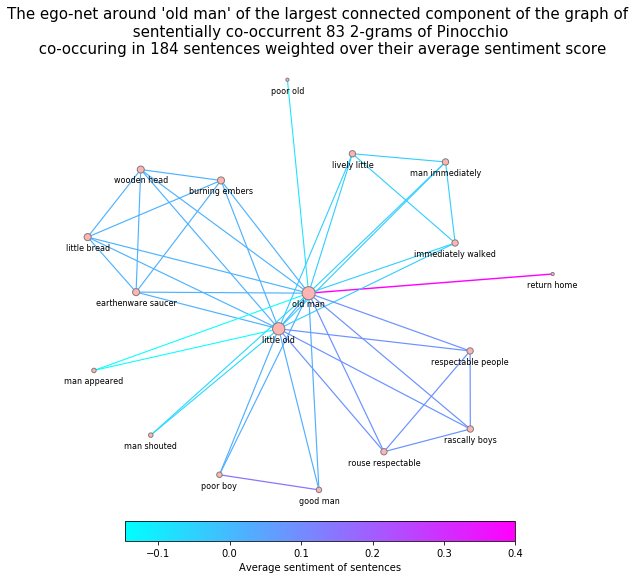

In [18]:
Gwlcc=egoNet

figsize=(10,10)

cmap=plt.cm.cool
weight_list = [ e[2]['weight'] for e in Gwlcc.edges(data=True) ]

edge_color=weight_list
vmin = min(edge_color) 
vmax = max(edge_color) 
width_list=[1.5*math.log(abs(min(weight_list))+2+w) for w in weight_list] #weight_list

pos=graphviz_layout(Gwlcc) 
node_color="#ffb3b3"
node_border_color="grey"
# edge_color="#668cff"

d = Gwlcc.degree()
node_size=[10*v[1] for v in list(nx.degree(Gwlcc))]

plt.figure(figsize=figsize);
nodes = nx.draw_networkx_nodes(Gwlcc, pos,node_color=node_color,node_size=node_size)
nodes.set_edgecolor(node_border_color)
# nx.draw_networkx_edges(G, pos, edge_color=edge_color,width=edge_width,a=1)
nx.draw_networkx_edges(Gwlcc, pos,width=width_list,edge_color=edge_color,edge_cmap=cmap,vmin=vmin, vmax=vmax,alpha=1)
# nx.draw_networkx_labels(G, pos)
# nx.draw_networkx_edge_labels(G,pos,edge_labels=elabels);
plt.axis('off');
yoffset = {}
y_off = -5   # offset on the y axis
for k, v in pos.items():
    yoffset[k] = (v[0], v[1]+y_off)
nx.draw_networkx_labels(Gwlcc, yoffset,font_size=8);
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, orientation='horizontal', shrink=0.7, pad = 0.02)
cbar.set_label('Average sentiment of sentences')
sst="The ego-net around '%s' of the largest connected component of the graph of \n sententially co-occurrent %i 2-grams of %s \n co-occuring in %i sentences weighted over their average sentiment score" %(ego,NN,titlename,SS) 
plt.title(sst,fontsize=15);
plt.margins(x=0.1, y=0.05) 